In [1]:
import pandas as pd

# Load the dataset from the GitHub repository
url = 'https://raw.githubusercontent.com/gregversteeg/LinearCorex/master/tests/data/test_big5.csv'
df = pd.read_csv(url)

# Display basic information about the dataset
print("Number of instances in the dataset:", df.shape[0])
print("Number of columns in the dataset:", df.shape[1])
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display additional information
print("\nData Types and Non-Null Counts:")
print(df.info())

Number of instances in the dataset: 2000
Number of columns in the dataset: 50

First 5 rows of the dataset:
   blue_q0  red_q1  green_q2  purple_q3  q4  blue_q5  red_q6  green_q7  \
0        2       0         3          1   4        1       4         1   
1        2       0         1          2   2        1       4         3   
2        3       0         2          1   3        1       4         3   
3        2       0         1          1   1        0       4         1   
4        2       0         1          1   3        0       4         3   

   purple_q8  q9  ...  blue_q40  red_q41  green_q42  purple_q43  q44  \
0          2   2  ...         3        3          3           2    3   
1          3   1  ...         2        3          2           2    3   
2          3   0  ...         4        4          2           1    4   
3          3   1  ...         1        2          2           1    3   
4          2   0  ...         3        4          1           3    4   

   blue_q45  r

In [2]:
df = df / 4.0
# print(df.head())

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target (Y) if necessary.
# In the case of autoencoder-like models, we do not have target Y, so we'll treat the whole dataset as X.
X = df.values  # Convert the DataFrame into a NumPy array for model input

# Split the dataset into training (80%) and testing sets (20%)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Output the shapes to verify
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1600, 50)
Test set shape: (400, 50)


In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert the DataFrame to a NumPy array
data_array = df.to_numpy()

# Convert the data to a PyTorch tensor
data_tensor = torch.tensor(data_array, dtype=torch.float32)

# Create a PyTorch dataset
dataset = TensorDataset(data_tensor)

# Split the dataset into training and validation sets (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for the training and validation sets
batch_size = 32  # You can adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Display the shape of the tensor to verify
print(f"Data tensor shape: {data_tensor.shape}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Data tensor shape: torch.Size([2000, 50])
Number of training batches: 50
Number of validation batches: 13


In [5]:
# Import necessary libraries
import torch
import torch.nn as nn

# Encoder class
class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim, hidden_dims=[]):
        super(Encoder, self).__init__()
        # Define the layers of the MLP
        dims = [input_dim] + hidden_dims + [output_dim]
        layers = []
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:
                layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)

        # Learnable embedding vectors e_i for each z_i
        self.e = nn.Parameter(torch.randn(output_dim, embedding_dim))
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim

    def forward(self, x):
        # Pass the input through the MLP to get Z
        Z = self.mlp(x)  # Shape: (batch_size, output_dim)

        # Convert Z to \hat Z by multiplying each scalar z_i with its own embedding vector e_i
        batch_size = Z.size(0)
        Z_expanded = Z.unsqueeze(2)                         # Shape: (batch_size, output_dim, 1)
        e_expanded = self.e.unsqueeze(0)                    # Shape: (1, output_dim, embedding_dim)
        hat_Z = Z_expanded * e_expanded                     # Shape: (batch_size, output_dim, embedding_dim)

        return hat_Z


In [6]:
class Decoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dims=[]):
        super(Decoder, self).__init__()
        self.input_dim = input_dim      # Number of observed variables (n)
        self.embedding_dim = embedding_dim

        # Learnable query embeddings (e1, e2, ..., en)
        self.query_embeddings = nn.Parameter(torch.randn(input_dim, embedding_dim))

        # MultiheadAttention module with 1 head
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=1, batch_first=True)

        # Layer normalization
        self.layer_norm = nn.LayerNorm(embedding_dim)

        # MLP to predict x_i's from embeddings
        dims = [embedding_dim] + hidden_dims + [1]
        layers = []
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:
                layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)

    def forward(self, hat_Z):
        """
        hat_Z: Tensor of shape (batch_size, output_dim, embedding_dim)
        """
        batch_size = hat_Z.size(0)

        # Prepare query embeddings and expand to batch size
        query_embeddings = self.query_embeddings.unsqueeze(0).expand(batch_size, -1, -1)  # Shape: (batch_size, input_dim, embedding_dim)

        # Apply scaled dot-product attention
        attn_output, attn_weights = self.attention(query_embeddings, hat_Z, hat_Z)        # Output shape: (batch_size, input_dim, embedding_dim)

        # Add residual connection and apply layer normalization
        out = self.layer_norm(attn_output + query_embeddings)                             # Shape: (batch_size, input_dim, embedding_dim)

        # Flatten the embeddings and pass through MLP to predict x_i's
        out_flat = out.reshape(-1, self.embedding_dim)                                    # Shape: (batch_size * input_dim, embedding_dim)
        x_hat_flat = self.mlp(out_flat)                                                   # Shape: (batch_size * input_dim, 1)
        x_hat = x_hat_flat.view(batch_size, self.input_dim)                               # Shape: (batch_size, input_dim)

        return x_hat, attn_weights  # Return attention weights


In [7]:
# Complete model combining the encoder and decoder
class Model(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim, encoder_hidden_dims=[], decoder_hidden_dims=[]):
        super(Model, self).__init__()
        self.encoder = Encoder(input_dim=input_dim, output_dim=output_dim, embedding_dim=embedding_dim, hidden_dims=encoder_hidden_dims)
        self.decoder = Decoder(input_dim=input_dim, embedding_dim=embedding_dim, hidden_dims=decoder_hidden_dims)

    def forward(self, x):
        hat_Z = self.encoder(x)     # Obtain \hat Z from the encoder
        x_hat, attn_weights = self.decoder(hat_Z) # Reconstruct x from \hat Z using the decoder
        return x_hat, attn_weights

In [8]:
import os
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Assume that the Encoder, Decoder, and Model classes are already defined

# Define dimensions
input_dim = 50        # Number of observed variables
output_dim = 5        # Output dimension of the encoder (dimension of Z)
embedding_dim = 64    # Embedding dimension for the embeddings e and e_i's
encoder_hidden_dims = [128, 64]  # Hidden dimensions for the encoder
decoder_hidden_dims = [64, 32]   # Hidden dimensions for the decoder

# Instantiate the model
model = Model(
    input_dim=input_dim,
    output_dim=output_dim,
    embedding_dim=embedding_dim,
    encoder_hidden_dims=encoder_hidden_dims,
    decoder_hidden_dims=decoder_hidden_dims
)

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 200          # Number of epochs
batch_size = 32          # Batch size (already set in the DataLoader)
print_every = 1          # How often to print loss (in epochs)

# Define the maximum value for the entropy regularization coefficient
max_lambda_entropy = 1e-3  # Adjust this value as needed

# Flag to enable or disable entropy regularizer
use_entropy_regularizer = True  # Set to True to enable, False to disable

# Scheduler function for lambda_entropy
def get_lambda_entropy(epoch, num_epochs, max_lambda_entropy, schedule_type='exponential', use_entropy_regularizer=True):
    if not use_entropy_regularizer:
        return 0.0
    if schedule_type == 'linear':
        # Linear increase from 0 to max_lambda_entropy
        return max_lambda_entropy * (epoch / num_epochs)
    elif schedule_type == 'exponential':
        # Exponential increase from 0 to max_lambda_entropy
        k = 5  # Adjust this value to control the speed of increase
        return max_lambda_entropy * (1 - math.exp(-k * epoch / num_epochs))
    elif schedule_type == 'logarithmic':
        # Logarithmic increase from 0 to max_lambda_entropy
        if epoch == 0:
            return 0.0
        else:
            return max_lambda_entropy * math.log(epoch + 1) / math.log(num_epochs + 1)
    else:
        raise ValueError(f"Unknown schedule_type: {schedule_type}")

model_path = "trained_model.pth"
if os.path.exists(model_path):
    print("Trained model found. Loading the model.")
    model.load_state_dict(torch.load(model_path))
    print("Model loaded successfully!")

# Training loop with validation
for epoch in range(num_epochs):
    # Compute lambda_entropy for the current epoch
    lambda_entropy = get_lambda_entropy(
        epoch, num_epochs, max_lambda_entropy, schedule_type='linear', use_entropy_regularizer=use_entropy_regularizer)

    # Training phase
    model.train()
    running_loss = 0.0          # Accumulates total loss (reconstruction + regularizer)
    running_recon_loss = 0.0    # Accumulates reconstruction loss
    for batch_idx, (batch,) in enumerate(train_loader):
        batch = batch.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted x_hat and attention weights
        x_hat, attn_weights = model(batch)

        # Compute the reconstruction loss
        recon_loss = criterion(x_hat, batch)

        # Initialize entropy_regularizer to zero
        entropy_regularizer = 0.0

        # Compute the entropy regularizer if enabled
        if use_entropy_regularizer:
            attn_weights = attn_weights.squeeze(1)  # Shape: (batch_size, input_dim, output_dim)

            # Add a small epsilon to prevent log(0)
            epsilon = 1e-8

            # Compute entropy for each query (input_dim)
            entropy = -torch.sum(attn_weights * torch.log(attn_weights + epsilon), dim=2)  # Shape: (batch_size, input_dim)

            # Sum entropies over queries and average over batch
            entropy_regularizer = torch.mean(torch.sum(entropy, dim=1))  # Scalar

        # Total loss
        loss = recon_loss + lambda_entropy * entropy_regularizer

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate training losses
        running_loss += loss.item()
        running_recon_loss += recon_loss.item()

    # Compute average losses for training
    avg_train_loss = running_loss / len(train_loader)
    avg_train_recon_loss = running_recon_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0          # Accumulates total loss (reconstruction + regularizer)
    val_recon_loss = 0.0    # Accumulates reconstruction loss
    with torch.no_grad():
        for batch_idx, (batch,) in enumerate(val_loader):
            batch = batch.to(device)

            # Forward pass for validation
            x_hat, attn_weights = model(batch)

            # Compute the reconstruction loss
            recon_loss = criterion(x_hat, batch)

            # Initialize entropy_regularizer to zero
            entropy_regularizer = 0.0

            # Compute the entropy regularizer if enabled
            if use_entropy_regularizer:
                attn_weights = attn_weights.squeeze(1)  # Shape: (batch_size, input_dim, output_dim)

                # Add a small epsilon to prevent log(0)
                epsilon = 1e-8

                # Compute entropy for each query (input_dim)
                entropy = -torch.sum(attn_weights * torch.log(attn_weights + epsilon), dim=2)  # Shape: (batch_size, input_dim)

                # Sum entropies over queries and average over batch
                entropy_regularizer = torch.mean(torch.sum(entropy, dim=1))  # Scalar

            # Total loss
            loss = recon_loss + lambda_entropy * entropy_regularizer

            # Accumulate validation losses
            val_loss += loss.item()
            val_recon_loss += recon_loss.item()

    # Compute average losses for validation
    avg_val_loss = val_loss / len(val_loader)
    avg_val_recon_loss = val_recon_loss / len(val_loader)

    # Print average losses for the epoch
    if (epoch + 1) % print_every == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Lambda Entropy: {lambda_entropy:.6f}, '
              f'Train Total Loss: {avg_train_loss:.4f}, Train Recon Loss: {avg_train_recon_loss:.4f}, '
              f'Val Total Loss: {avg_val_loss:.4f}, Val Recon Loss: {avg_val_recon_loss:.4f}')

# Save the trained model after training
torch.save(model.state_dict(), "trained_model.pth")
print("Training complete and model saved.")

Epoch [1/200], Lambda Entropy: 0.000000, Train Total Loss: 0.1567, Train Recon Loss: 0.1567, Val Total Loss: 0.0911, Val Recon Loss: 0.0911
Epoch [2/200], Lambda Entropy: 0.000005, Train Total Loss: 0.0860, Train Recon Loss: 0.0857, Val Total Loss: 0.0856, Val Recon Loss: 0.0853
Epoch [3/200], Lambda Entropy: 0.000010, Train Total Loss: 0.0797, Train Recon Loss: 0.0791, Val Total Loss: 0.0759, Val Recon Loss: 0.0754
Epoch [4/200], Lambda Entropy: 0.000015, Train Total Loss: 0.0720, Train Recon Loss: 0.0713, Val Total Loss: 0.0691, Val Recon Loss: 0.0685
Epoch [5/200], Lambda Entropy: 0.000020, Train Total Loss: 0.0672, Train Recon Loss: 0.0663, Val Total Loss: 0.0655, Val Recon Loss: 0.0646
Epoch [6/200], Lambda Entropy: 0.000025, Train Total Loss: 0.0640, Train Recon Loss: 0.0630, Val Total Loss: 0.0635, Val Recon Loss: 0.0625
Epoch [7/200], Lambda Entropy: 0.000030, Train Total Loss: 0.0624, Train Recon Loss: 0.0613, Val Total Loss: 0.0617, Val Recon Loss: 0.0607
Epoch [8/200], Lambd

In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Function to compute average attention matrix
def compute_average_attention(model, dataloader, device):
    model.eval()  # Ensure model is in evaluation mode
    total_attn = None
    num_batches = 0

    with torch.no_grad():
        for data in dataloader:
            # Assuming data is a tuple (inputs, labels), adjust as needed
            inputs = data[0].to(device)

            # Forward pass up to obtaining attention weights
            hat_Z = model.encoder(inputs)
            _, attn_weights = model.decoder(hat_Z)

            # attn_weights shape: (batch_size, input_dim, output_dim)
            # Sum attention weights over batches
            if total_attn is None:
                total_attn = attn_weights.sum(dim=0)  # Sum over batch dimension
            else:
                total_attn += attn_weights.sum(dim=0)
            num_batches += attn_weights.size(0)  # Accumulate total number of samples

    # Average the attention weights
    avg_attn = total_attn / num_batches

    return avg_attn.cpu().numpy()


In [10]:
# Assuming you have your dataloaders defined as train_loader and val_loader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Compute average attention matrices
avg_attn_train = compute_average_attention(model, train_loader, device)
avg_attn_val = compute_average_attention(model, val_loader, device)


In [11]:
# Assuming 'df' is your original dataframe

# Identify column prefixes for each true factor
factor_columns = {
    'Factor1': [col for col in df.columns if col.startswith('blue')],
    'Factor2': [col for col in df.columns if col.startswith('green')],
    'Factor3': [col for col in df.columns if col.startswith('purple')],
    'Factor4': [col for col in df.columns if col.startswith('red')],
    'Factor5': [col for col in df.columns if col.startswith('q')]
}

# Map factor names to column indices
factor_indices = {}
for factor_name, columns in factor_columns.items():
    indices = [df.columns.get_loc(col) for col in columns]
    factor_indices[factor_name] = indices


In [12]:
import numpy as np
from sklearn.metrics import adjusted_rand_score

# Assuming 'avg_attn_train' is the average attention matrix from the training set
# Shape of avg_attn_train: (input_dim, output_dim)

# Assuming 'factor_indices' is a dictionary mapping factor names to lists of query indices
# Example:
# factor_indices = {
#     'Factor1': [0, 1, 2, ...],
#     'Factor2': [10, 11, 12, ...],
#     ...
# }

# Number of queries and keys
input_dim = avg_attn_train.shape[0]   # Number of queries (50)
output_dim = avg_attn_train.shape[1]  # Number of keys (5)

# Define a small epsilon to consider as threshold for non-zero attention
epsilon = 1e-6

# Step 1: For each key, find query indices with non-zero attention scores
key_groups = {}  # Dictionary to hold groups based on attention
for key_index in range(output_dim):
    # Get attention scores for all queries for this key
    attn_scores = avg_attn_train[:, key_index]  # Shape: (input_dim,)
    # Find query indices where attention score > epsilon
    query_indices = np.where(attn_scores > epsilon)[0]
    key_groups[key_index] = query_indices

# Step 2: Assign each query index to the key with the highest attention score
predicted_labels = np.argmax(avg_attn_train, axis=1)  # Shape: (input_dim,)

# Note: In case of ties or all zeros, argmax returns the first occurrence.
# If necessary, you can handle cases where all attention scores are zero.

# Step 3: Create true labels based on ideal groups
true_labels = np.full(input_dim, -1)  # Initialize with -1

# Map factor names to indices
factor_names = ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5']
factor_name_to_index = {name: idx for idx, name in enumerate(factor_names)}

# Assign labels to queries based on factors
for factor_name, indices in factor_indices.items():
    factor_idx = factor_name_to_index[factor_name]
    true_labels[indices] = factor_idx

# Ensure all query indices have been assigned
assert np.all(true_labels >= 0), "Some query indices have not been assigned a true label"

# Step 4: Compute Adjusted Rand Index
ari = adjusted_rand_score(true_labels, predicted_labels)

print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.0896399706098457


In [13]:
# Create a new ordering of indices
new_order = []
for factor_name in factor_columns.keys():
    new_order.extend(factor_indices[factor_name])

# Ensure all indices are included
assert len(new_order) == df.shape[1], "Not all indices are included in the new order."

In [14]:
# Transpose the average attention matrices
avg_attn_train_transposed = avg_attn_train.T  # Shape: (output_dim, input_dim)
avg_attn_val_transposed = avg_attn_val.T      # Shape: (output_dim, input_dim)

# Rearrange the columns (queries) using new_order
avg_attn_train_reordered = avg_attn_train_transposed[:, new_order]
avg_attn_val_reordered = avg_attn_val_transposed[:, new_order]

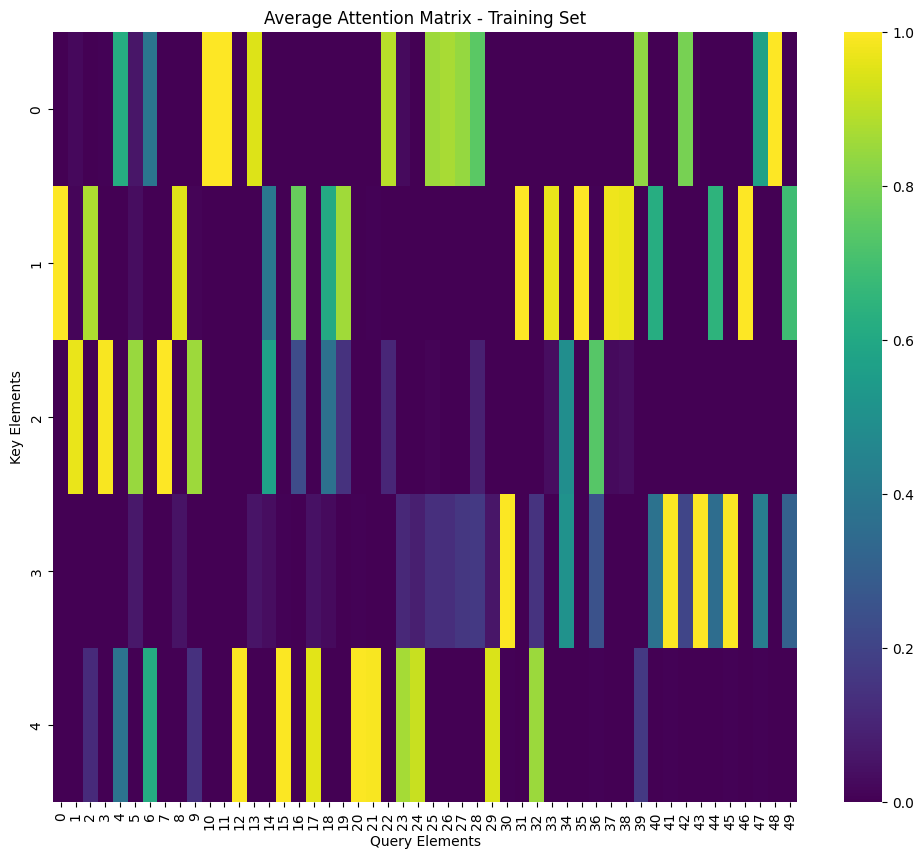

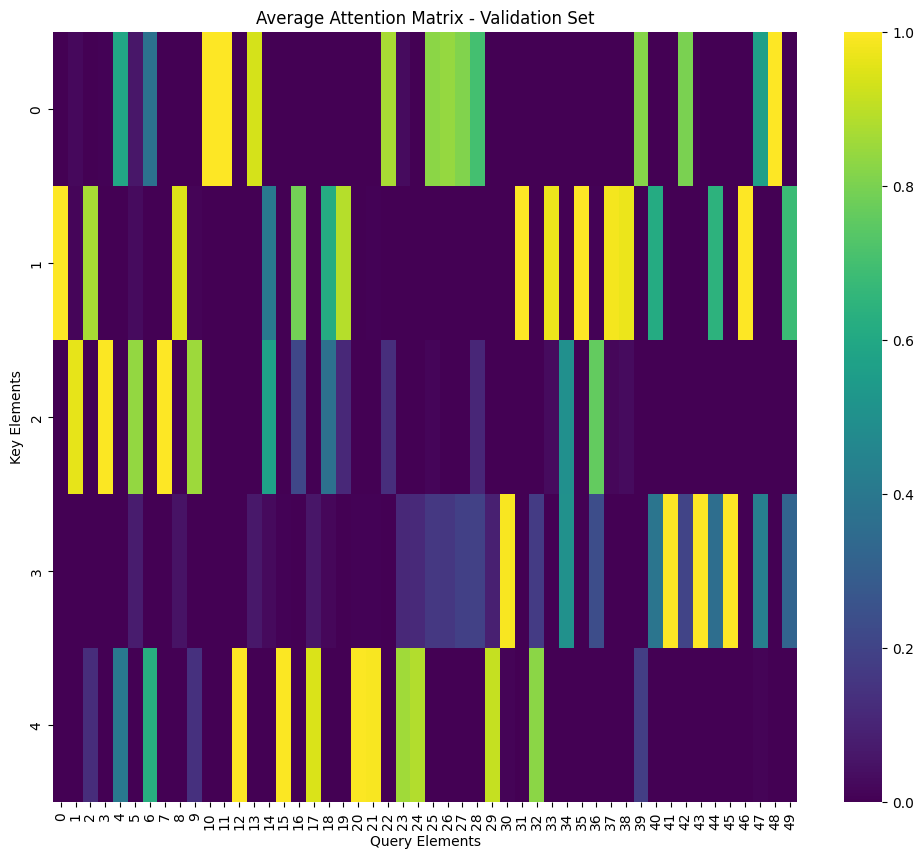

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_attention_heatmap(attn_matrix, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(attn_matrix, cmap='viridis')
    plt.title(title)
    plt.xlabel('Query Elements')  # Queries are now along X-axis
    plt.ylabel('Key Elements')    # Keys are now along Y-axis
    plt.show()

# Plot average attention matrices
plot_attention_heatmap(avg_attn_train_reordered, 'Average Attention Matrix - Training Set')
plot_attention_heatmap(avg_attn_val_reordered, 'Average Attention Matrix - Validation Set')
